In [47]:
import os
import re
import time
import logging
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords

import gensim
from gensim.models import word2vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [48]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
DATASET_PATH = "..\\data\\processed\\gojek_reviews_preprocessed.csv"
DATASET_COLUMNS = ["label", "content"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

In [50]:
text_cleaning = "@\S+|https?:\/\/\S+|http?:\/\/\S|[^a-zA-Z0-9]+"

In [51]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [52]:
sequence_length = 300
epochs = 20
batch_size = 256

In [53]:
positive = "positive"
negative = "negative"
neutral = "neutral"
sentiment_threshold = (0.4, 0.7)  

In [54]:
keras_model = "model.h5"
word2vec_model = "model.w2v"
tokenizer_path = "tokenizer.pkl"
label_encoder_path = "label_encoder.pkl"

In [55]:
print("Loading dataset...")
df = pd.read_csv(DATASET_PATH, names=DATASET_COLUMNS, delimiter=',', encoding=DATASET_ENCODING, skiprows=1)
print("Dataset size:", len(df))
print(df.head())

Loading dataset...
Dataset size: 98558
                                                                                                                                                                                                                   label  \
1c637a3a-43d8-453a-8da5-48a2d26927bc Sudarto       sangat membantu                                    5 0 2025-10-28T00:53:58 NaN                                                NaN                 5.31.2 id  positive   
e851b0c8-862d-4dca-b2db-875e6c03a625 kamu nanya    terlalu lama mendapatkan driver di daerah cipan... 1 0 2025-10-28T00:53:22 Mohon maaf ya, Kak @kamu nanya. Kesulitan menda... 2025-10-28T07:01:18 5.35.1 id  negative   
1dab09ce-061f-4751-b58c-ef12b03753b8 FTHR          sampai saat ini masih oke                          5 0 2025-10-28T00:00:17 NaN                                                NaN                 5.36.2 id  positive   
da593ef8-bc9f-42ce-8aac-3ab0bb5e768f Safitri Yenii sangat membantu saya          

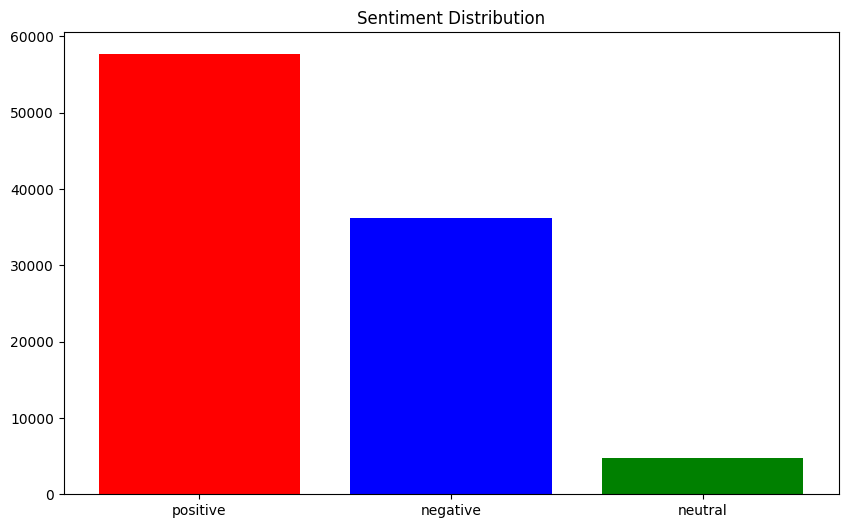

In [56]:
decode_map = {0: negative, 1: neutral, 2: positive}
def decode_sentiment(label):
    return decode_map.get(int(label), "neutral")
# df['label'] = df['label'].apply(lambda x: decode_sentiment(x))
plt.figure(figsize=(10,6))
label_counts = Counter(df['label'])
plt.bar(label_counts.keys(), label_counts.values(), color=['red', 'blue', 'green'])
plt.title("Sentiment Distribution")
plt.show()

In [57]:
list_stopwords = stopwords.words("indonesian")
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", "klo", "kalo", "amp",
                       "biar", "bikin", "bilang", "gak", "ga", "krn", "nya", "nih",
                       "sih", "si", "tau", "tdk", "tuh", "utk", "ya", "jd", "jgn",
                       "sdh", "aja", "n", "t", "nyg", "hehe", "pen", "u", "nan",
                       "loh", "rt", "&amp", "yah"])

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [58]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in list_stopwords:
            tokens.append(stemmer.stem(token) if stem else token)
    return " ".join(tokens)

print("Cleaning text...")
df["content"] = df["content"].apply(lambda x: preprocess(x))

Cleaning text...


In [59]:
df_train, df_test = train_test_split(df, test_size=1 - TRAIN_SIZE, random_state=42)
print("Train size:", len(df_train))
print("Test size:", len(df_test))

documents = [_text.split() for _text in df_train.content]

Train size: 78846
Test size: 19712


In [60]:
print("Training Word2Vec model...")
w2v_model = word2vec.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
w2v_model.build_vocab(documents)
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
print("Vocab size:", len(w2v_model.wv))

2025-10-31 15:11:01,440 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2025-10-31T15:11:01.439636', 'gensim': '4.4.0', 'python': '3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-10-31 15:11:01,447 : INFO : collecting all words and their counts
2025-10-31 15:11:01,448 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-10-31 15:11:01,464 : INFO : PROGRESS: at sentence #10000, processed 67024 words, keeping 7722 word types
2025-10-31 15:11:01,478 : INFO : PROGRESS: at sentence #20000, processed 133538 words, keeping 12395 word types
2025-10-31 15:11:01,493 : INFO : PROGRESS: at sentence #30000, processed 201176 words, keeping 16543 word types
2025-10-31 15:11:01,506 : INFO : PROGRESS: at sentence #40000, processed 268876 words, keeping 20438 word types
2025-10-31 15:11:01,521 : INFO : PR

Training Word2Vec model...


2025-10-31 15:11:01,622 : INFO : sample=0.001 downsamples 73 most-common words
2025-10-31 15:11:01,623 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 358112.0578258167 word corpus (74.1%% of prior 482972)', 'datetime': '2025-10-31T15:11:01.623699', 'gensim': '4.4.0', 'python': '3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-10-31 15:11:01,642 : INFO : estimated required memory for 2484 words and 300 dimensions: 7203600 bytes
2025-10-31 15:11:01,643 : INFO : resetting layer weights
2025-10-31 15:11:01,650 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2025-10-31T15:11:01.650698', 'gensim': '4.4.0', 'python': '3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'build_vocab'}
2025-10-31 15:11:01,651 : INFO : Word

Vocab size: 2484


In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)
vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content), maxlen=sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content), maxlen=sequence_length)


In [62]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(encoder.transform(df_train.label.tolist()), num_classes=3)
y_test = to_categorical(encoder.transform(df_test.label.tolist()), num_classes=3)

In [63]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=sequence_length, trainable=False)

c:\Users\rahel\miniconda3\envs\asah\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [64]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    10,053,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,053,300 (38.35 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,053,300 (38.35 MB)

In [65]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_true_idx),
    y=y_true_idx
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 235s 836ms/step - accuracy: 0.7295 - loss: 0.7718 - val_accuracy: 0.7622 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 249s 895ms/step - accuracy: 0.7483 - loss: 0.7258 - val_accuracy: 0.7528 - val_loss: 0.6027 - learning_rate: 0.0010
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 260s 935ms/step - accuracy: 0.7539 - loss: 0.7073 - val_accuracy: 0.7791 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 251s 903ms/step - accuracy: 0.7603 - loss: 0.6941 - val_accuracy: 0.7456 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 239s 858ms/step - accuracy: 0.7611 - loss: 0.6891 - val_accuracy: 0.7495 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 240s 864ms/step - accuracy: 0.7645 - loss: 0.6808 - val_accuracy: 0.7620 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 239s 858ms/step - accura

77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.7595 - loss: 0.5821

Accuracy: 0.7595
Loss: 0.5821


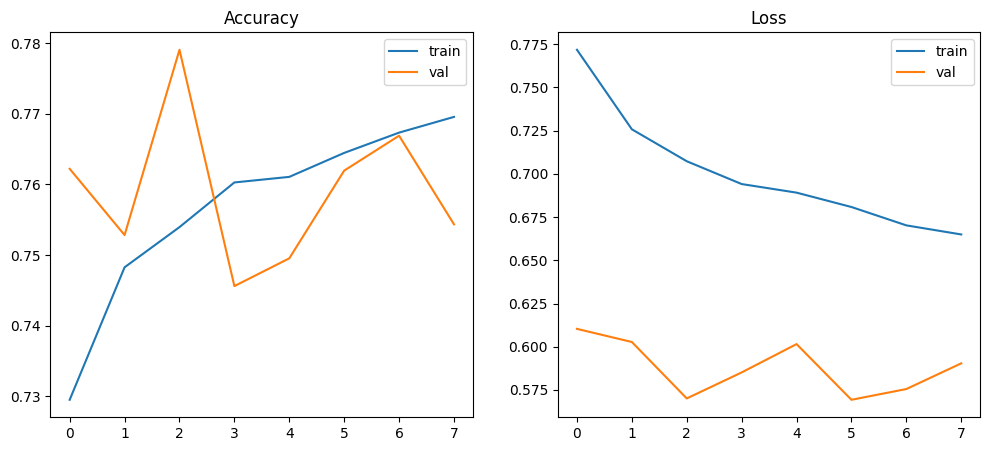

In [66]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"\nAccuracy: {score[1]:.4f}")
print(f"Loss: {score[0]:.4f}")

# PLOT TRAINING CURVES
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
def decode_sentiment_score(score, include_neutral=True):
    if include_neutral:
        if score <= sentiment_threshold[0]:
            return negative
        elif score >= sentiment_threshold[1]:
            return positive
        return neutral
    else:
        return negative if score < 0.5 else positive

def predict(text):
    x_input = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=sequence_length)
    probs = model.predict(x_input, verbose=0)[0]
    idx = np.arg!!p!!!!jhhhhhhhooiinnmax(probs)
    label = encoder.inverse_transform([idx])[0]
    return {"text": text, "predicted_label": label, "probabilities": probs.tolist()}

print(predict("driver dan pihak app gojek tidak ada penyelesaian uang saya 50000 hangus sia siaa. buat laporan tapi uang ga kembali juga"))
print(predict("aplikasi anak negeri terbaik"))
print(predict("aplikasi ga jelas, anehhh, hapus aja gapenting"))

{'text': 'driver dan pihak app gojek tidak ada penyelesaian uang saya 50000 hangus sia siaa. buat laporan tapi uang ga kembali juga', 'predicted_label': np.str_('negative'), 'probabilities': [0.7857287526130676, 0.19452175498008728, 0.019749486818909645]}
{'text': 'aplikasi anak negeri terbaik', 'predicted_label': np.str_('positive'), 'probabilities': [0.0670720711350441, 0.10574726015329361, 0.8271806836128235]}
{'text': 'aplikasi ga jelas, anehhh, hapus aja gapenting', 'predicted_label': np.str_('negative'), 'probabilities': [0.8581320643424988, 0.1086113303899765, 0.033256638795137405]}


616/616 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step
Accuracy: 0.7594866071428571
              precision    recall  f1-score   support

    negative       0.85      0.63      0.72      7246
     neutral       0.13      0.54      0.20       914
    positive       0.96      0.86      0.91     11552

    accuracy                           0.76     19712
   macro avg       0.64      0.68      0.61     19712
weighted avg       0.88      0.76      0.80     19712



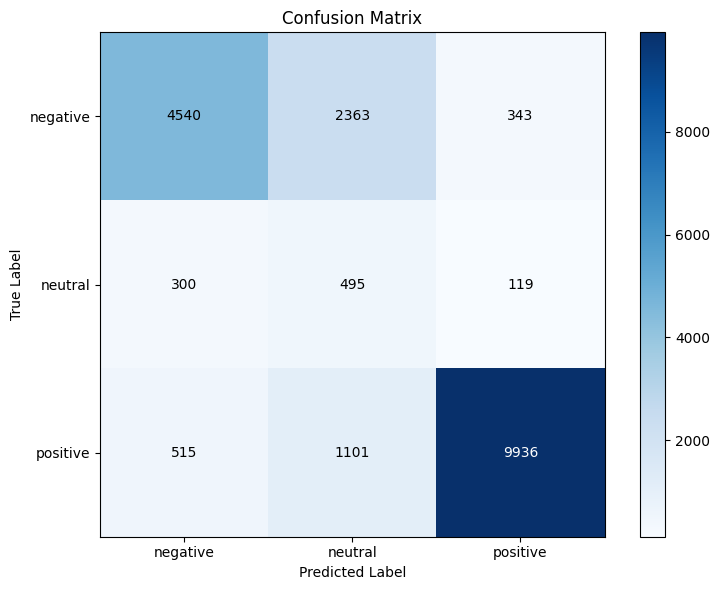

In [68]:
y_pred_scores = model.predict(x_test, verbose=1)

y_pred_idx = np.argmax(y_pred_scores, axis=1)
y_true_idx = np.argmax(y_test, axis=1)

y_pred_labels = encoder.inverse_transform(y_pred_idx)
y_true_labels = encoder.inverse_transform(y_true_idx)

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['negative', 'neutral', 'positive']
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
